In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import f, norm, pearsonr, ttest_rel

# Load data
study_name = "Accuracy Nudge"
specification_name = "default persona"
human_file = f"{study_name} human data values anonymized.csv"
twin_file = f"{study_name} twins data values anonymized.csv"
df_human = pd.read_csv(human_file, header=0, skiprows=[1, 2])
df_twin = pd.read_csv(twin_file, header=0, skiprows=[1, 2])


# Compute results
results = []

# define relevant columns:
# condition variable names:
condition_vars = ["Condition"]
# Check if we have a real condition var
if condition_vars and condition_vars[0].strip():
    cond = condition_vars[0]
    cond_h = f"{cond}_human"
    cond_t = f"{cond}_twin"
    cond_exists = True
else:
    cond_exists = False


# raw responses:
raw_vars = []

# DVs:
# DV_vars=['task 1 - attitude_change','task 2 - S1','task 2 - S2','task 2 - S3','task 3 - S1','task 3 - S2','task 3 - S3']
DV_vars = [f"Fake{i}_3" for i in range(1, 9)] + [f"Real{i}_3" for i in range(1, 9)]
DV_vars_min = [1] * 16
DV_vars_max = [6] * 16
# DVs: domain=social?
DV_vars_social = [1] * 16
DV_vars_social_map = dict(zip(DV_vars, DV_vars_social))
# DVs: domain=cognitive?
DV_vars_cognitive = [0] * 16
DV_vars_cognitive_map = dict(zip(DV_vars, DV_vars_cognitive))
# DVs: replicating know human bias?
DV_vars_known = [0] * 16
DV_vars_known_map = dict(zip(DV_vars, DV_vars_known))
# DVs: preference measure?
DV_vars_pref = [1] * 16
DV_vars_pref_map = dict(zip(DV_vars, DV_vars_pref))
# DVs: stimuli dependent?
DV_vars_stim = [0] * 16
DV_vars_stim_map = dict(zip(DV_vars, DV_vars_stim))
# DVs: knowledge question?
DV_vars_know = [0] * 16
DV_vars_know_map = dict(zip(DV_vars, DV_vars_know))
# DVs: political question?
DV_vars_politics = [0] * 16
DV_vars_politics_map = dict(zip(DV_vars, DV_vars_politics))


# merging key
merge_key = ["TWIN_ID"]

# Merge on TWIN_ID
df = pd.merge(df_human, df_twin, on=merge_key, suffixes=("_human", "_twin"))

print("Merged df columns:", df.columns.tolist())

# Fix dtypes
for var in raw_vars + DV_vars:
    df[f"{var}_human"] = pd.to_numeric(df[f"{var}_human"], errors="coerce")
    df[f"{var}_twin"] = pd.to_numeric(df[f"{var}_twin"], errors="coerce")

# build min/max maps from both raw_vars and DV_vars
min_map = {v: mn for v, mn in zip(DV_vars, DV_vars_min)}
# min_map = {v: mn for v, mn in zip(raw_vars,      raw_vars_min)}
# min_map.update({v: mn for v, mn in zip(DV_vars,   DV_vars_min)})

max_map = {v: mx for v, mx in zip(DV_vars, DV_vars_max)}
# max_map = {v: mx for v, mx in zip(raw_vars,      raw_vars_max)}
# max_map.update({v: mx for v, mx in zip(DV_vars,   DV_vars_max)})

# now add _min and _max columns for every variable in the union
for var in min_map:
    df[f"{var}_min"] = min_map[var]
    df[f"{var}_max"] = max_map[var]

for var in DV_vars:
    col_h = f"{var}_human"
    col_t = f"{var}_twin"
    min_col = f"{var}_min"
    max_col = f"{var}_max"
    if cond_exists:
        cols = [col_h, col_t, cond_h, cond_t, min_col, max_col]
    else:
        cols = [col_h, col_t, min_col, max_col]
    pair = df[cols].dropna(subset=[col_h, col_t])

    min_val = pair[min_col].iloc[0]
    max_val = pair[max_col].iloc[0]
    n = len(pair)
    if n >= 4:
        r, _ = pearsonr(pair[col_h], pair[col_t])
        z_f = np.arctanh(r)
        se = 1 / np.sqrt(n - 3)
        z_crit = norm.ppf(0.975)
        lo_z, hi_z = z_f - z_crit * se, z_f + z_crit * se
        lo_r, hi_r = np.tanh(lo_z), np.tanh(hi_z)
        z_score = z_f / se
        # Accuracy = mean absolute diff / range
        if pd.isna(min_val) or pd.isna(max_val) or max_val == min_val:
            accuracy = np.nan
        else:
            # compute mean absolute difference
            abs_diff = np.abs(pair[col_h] - pair[col_t])
            mean_abs_diff = abs_diff.mean()
            accuracy = 1 - mean_abs_diff / (max_val - min_val)

        mean_h = pair[col_h].mean()
        mean_t = pair[col_t].mean()

        # Paired t‐test
        t_stat, p_val = ttest_rel(pair[col_h], pair[col_t])

        std_h = pair[col_h].std(ddof=1)
        std_t = pair[col_t].std(ddof=1)

        # F‐test for equal variances
        df1 = df2 = n - 1
        f_stat = (std_h**2 / std_t**2) if std_t > 0 else np.nan
        # two‐tailed p‐value:
        if not np.isnan(f_stat):
            p_f = 2 * min(f.cdf(f_stat, df1, df2), 1 - f.cdf(f_stat, df1, df2))
        else:
            p_f = np.nan

        # Effect sizes (Cohen's d) across conditions
        #    For humans:
        if cond_exists and len(pair) > 3:
            levels_h = pair[cond_h].unique()
            if len(levels_h) == 2:
                g1 = pair.loc[pair[cond_h] == levels_h[0], col_h]
                g2 = pair.loc[pair[cond_h] == levels_h[1], col_h]
                n1, n2 = len(g1), len(g2)
                # pooled sd
                s_pool = np.sqrt(
                    ((n1 - 1) * g1.var(ddof=1) + (n2 - 1) * g2.var(ddof=1)) / (n1 + n2 - 2)
                )
                d_human = (g1.mean() - g2.mean()) / s_pool if s_pool > 0 else np.nan
            else:
                d_human = np.nan
        else:
            d_human = np.nan

        #    For twins:
        if cond_exists and len(pair) > 3:
            levels_t = pair[cond_t].unique()
            if cond_exists and len(levels_t) == 2:
                g1 = pair.loc[pair[cond_t] == levels_t[0], col_t]
                g2 = pair.loc[pair[cond_t] == levels_t[1], col_t]
                n1, n2 = len(g1), len(g2)
                s_pool = np.sqrt(
                    ((n1 - 1) * g1.var(ddof=1) + (n2 - 1) * g2.var(ddof=1)) / (n1 + n2 - 2)
                )
                d_twin = (g1.mean() - g2.mean()) / s_pool if s_pool > 0 else np.nan
            else:
                d_twin = np.nan
        else:
            d_twin = np.nan
    else:
        r = lo_r = hi_r = z_score = accuracy = mean_h = mean_t = t_stat = p_val = std_h = std_t = (
            f_stat
        ) = p_f = np.nan
        d_human = d_twin = np.nan

    results.append(
        {
            "study name": study_name,
            "persona specification": specification_name,
            "variable name": var,
            #        'variable type (raw response/DV)':     'DV',
            "correlation between the responses from humans vs. their twins": r,
            "CI_lower": lo_r,
            "CI_upper": hi_r,
            "z-score for correlation between humans vs. their twins": z_score,
            "accuracy between humans vs. their twins": accuracy,
            "mean_human": mean_h,
            "mean_twin": mean_t,
            "paired t-test t-stat": t_stat,
            "paired t-test p-value": p_val,
            "std_human": std_h,
            "std_twin": std_t,
            "variance test F-stat": f_stat,
            "variance test p-value": p_f,
            "effect size based on human": d_human,
            "effect size based on twin": d_twin,
            "domain=social?": DV_vars_social_map.get(var, np.nan),
            "domain=cognitive?": DV_vars_cognitive_map.get(var, np.nan),
            "replicating know human bias?": DV_vars_known_map.get(var, np.nan),
            "preference measure?": DV_vars_pref_map.get(var, np.nan),
            "stimuli dependent?": DV_vars_stim_map.get(var, np.nan),
            "knowledge question?": DV_vars_know_map.get(var, np.nan),
            "political question?": DV_vars_politics_map.get(var, np.nan),
            "sample size": n,
        }
    )
################################################


# print results:

# results DataFrame
corr_df = pd.DataFrame(results)
print(corr_df)

# save output as csv - unit of observation is comparison between humans and twins:
out_file = f"{study_name} {specification_name} meta analysis.csv"
corr_df.to_csv(out_file, index=False)


##### participant‐level data
def make_long(df, respondent_type):
    # pick off TWIN_ID + the DVs, then melt
    long = df[["TWIN_ID"] + DV_vars].melt(
        id_vars="TWIN_ID", value_vars=DV_vars, var_name="variable_name", value_name="value"
    )
    long["respondent_type"] = respondent_type
    long["study_name"] = study_name
    long["specification_name"] = specification_name
    return long


# build the two halves
long_h = make_long(df_human, "human")
long_t = make_long(df_twin, "twin")

# stack them and keep only non-NaN values
df_long = pd.concat([long_h, long_t], ignore_index=True)
df_long = df_long[df_long["value"].notna()]

print(df_long.head())

# save output as csv - unit of observation is TWIN_ID (only non-NaNs)
out_file = f"{study_name} {specification_name} meta analysis individual level.csv"
df_long.to_csv(out_file, index=False)

print("done")

Merged df columns: ['StartDate_human', 'EndDate_human', 'Progress_human', 'Duration (in seconds)_human', 'Finished_human', 'RecordedDate_human', 'Browser_Browser_human', 'Browser_Version_human', 'Browser_Operating System_human', 'Browser_Resolution_human', 'Fake1_Funny_human', 'Fake1_RT_First Click_human', 'Fake1_RT_Last Click_human', 'Fake1_RT_Page Submit_human', 'Fake1_RT_Click Count_human', 'Fake2_Funny_human', 'Fake2_RT_First Click_human', 'Fake2_RT_Last Click_human', 'Fake2_RT_Page Submit_human', 'Fake2_RT_Click Count_human', 'Real1_Funny_human', 'Real1_RT_First Click_human', 'Real1_RT_Last Click_human', 'Real1_RT_Page Submit_human', 'Real1_RT_Click Count_human', 'Real2_Funny_human', 'Real2_RT_First Click_human', 'Real2_RT_Last Click_human', 'Real2_RT_Page Submit_human', 'Real2_RT_Click Count_human', 'Fake1_2_human', 'Fake1_RT_First Click.1_human', 'Fake1_RT_Last Click.1_human', 'Fake1_RT_Page Submit.1_human', 'Fake1_RT_Click Count.1_human', 'Fake2_2_human', 'Fake2_RT_First Click.

C:\Users\ot2107\AppData\Local\Temp\ipykernel_21720\2285578780.py:91: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{var}_min"] = min_map[var]
C:\Users\ot2107\AppData\Local\Temp\ipykernel_21720\2285578780.py:92: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{var}_max"] = max_map[var]


        study name persona specification variable name  \
0   Accuracy Nudge       default persona       Fake1_3   
1   Accuracy Nudge       default persona       Fake2_3   
2   Accuracy Nudge       default persona       Fake3_3   
3   Accuracy Nudge       default persona       Fake4_3   
4   Accuracy Nudge       default persona       Fake5_3   
5   Accuracy Nudge       default persona       Fake6_3   
6   Accuracy Nudge       default persona       Fake7_3   
7   Accuracy Nudge       default persona       Fake8_3   
8   Accuracy Nudge       default persona       Real1_3   
9   Accuracy Nudge       default persona       Real2_3   
10  Accuracy Nudge       default persona       Real3_3   
11  Accuracy Nudge       default persona       Real4_3   
12  Accuracy Nudge       default persona       Real5_3   
13  Accuracy Nudge       default persona       Real6_3   
14  Accuracy Nudge       default persona       Real7_3   
15  Accuracy Nudge       default persona       Real8_3   

    correlati

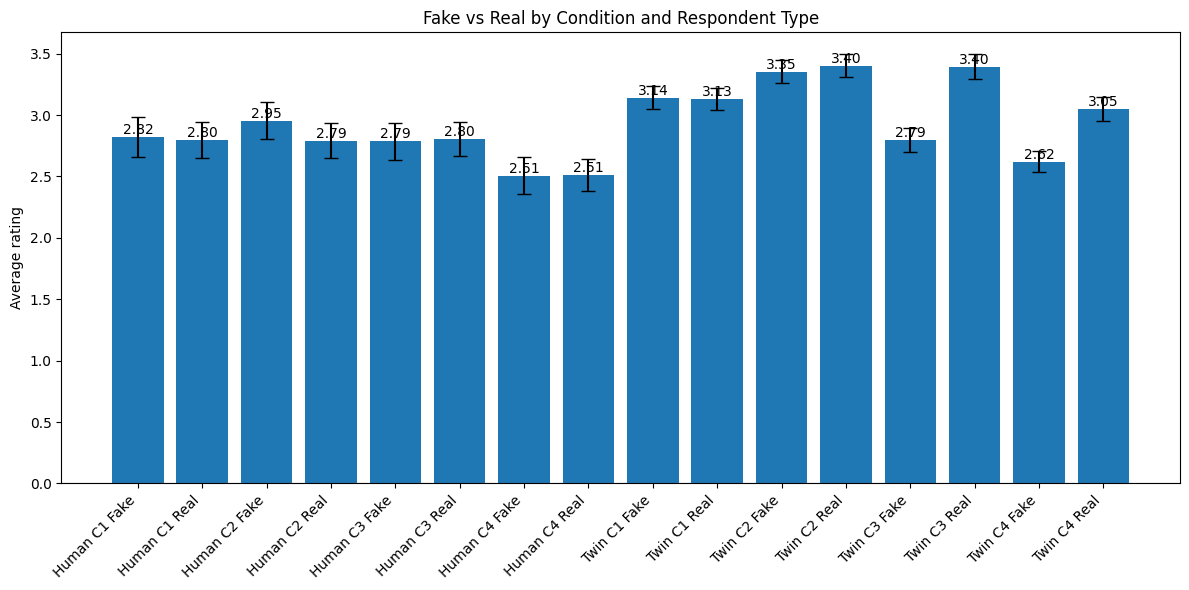

In [3]:
# bar chart:
import matplotlib.pyplot as plt
from scipy.stats import norm

# 1. set up
conditions_h = sorted(df_human["Condition"].dropna().unique())
conditions_t = sorted(df_twin["Condition"].dropna().unique())
z95 = norm.ppf(0.975)

mean_vals = []
ci_vals = []
labels = []


# 2. helper to compute per‑row averages and then group stats
def grp_stats(df, cond_var, cond_levels, prefix):
    for cond in cond_levels:
        grp = df[df[cond_var] == cond]
        # per‑participant average of Fake items, then Real items
        fake = grp[[f"Fake{i}_3" for i in range(1, 9)]].mean(axis=1, skipna=True)
        real = grp[[f"Real{i}_3" for i in range(1, 9)]].mean(axis=1, skipna=True)
        for vals, dom in [(fake, "Fake"), (real, "Real")]:
            m = vals.mean()
            n = vals.count()
            se = vals.std(ddof=1) / np.sqrt(n) if n > 1 else 0
            ci = z95 * se
            mean_vals.append(m)
            ci_vals.append(ci)
            labels.append(f"{prefix} C{cond} {dom}")


# 3. collect Human then Twin
grp_stats(df_human, "Condition", conditions_h, "Human")
grp_stats(df_twin, "Condition", conditions_t, "Twin")

# 4. plot
x = np.arange(len(mean_vals))
plt.figure(figsize=(12, 6))
bars = plt.bar(x, mean_vals, yerr=ci_vals, capsize=5)
plt.xticks(x, labels, rotation=45, ha="right")
plt.axhline(0, color="gray", linewidth=0.8)
plt.ylabel("Average rating")
plt.title("Fake vs Real by Condition and Respondent Type")

# 5. annotate means
for bar, m in zip(bars, mean_vals):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        m,
        f"{m:.2f}",
        ha="center",
        va="bottom" if m >= 0 else "top",
    )

plt.tight_layout()
plt.show()